# Load Data

In [8]:
import torch
torch.set_default_dtype(torch.float32)
import models
import models_1
from sphere_math import immersion


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n_trajectories = 10000
X0, V, pos = torch.load('data\X0.pt').to(device)[:n_trajectories].float(), torch.load('data\V.pt').to(device)[:n_trajectories].float(), torch.load('data\pos.pt').to(device)[:n_trajectories].float()
N = X0.shape[0]
n = V.shape[1]
# Data Preparation and Train-Test Splitting
train_test_split = 0.8
# X0_train = X0[:int(train_test_split*N)]
X0_test = X0[int(train_test_split*N):]
# V_train = V[:int(train_test_split*N)]
V_test = V[int(train_test_split*N):]
# pos_train = pos[:int(train_test_split*N)]
pos_test = pos[int(train_test_split*N):]

hidden_dims = [8, 16, 32, 64, 128]

pos_pred = X0_test.unsqueeze(dim=1) + V_test.cumsum(dim=1)
# errors_naive = (immersion(pos_test[800:1000]) - immersion(pos_pred[800:1000])).norm(dim=-1).mean(dim=0)
errors_naive = (immersion(pos_test) - immersion(pos_pred)).norm(dim=-1).mean(dim=0)

C:\Users\Sathya\AppData\Local\Temp\ipykernel_29708\522688557.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  X0, V, pos = torch.load('data\X0.pt').to(device)[:n_traject

In [3]:
pos_test.shape

torch.Size([2000, 100, 2])

In [2]:
errors_naive[9], errors_naive[99]

(tensor(0.0022), tensor(0.0088))

In [3]:
X0_test.shape

torch.Size([2000, 2])

Sketch of Analysis:
-1. Flops Inf, Flops BP
-2. E_10, E_100
-3. Median of errors at each i
-4. Plots of all models
-5. Compute errors of individual models
-6. Load weights of individual models


In [17]:
from fvcore.nn import FlopCountAnalysis
import matplotlib.pyplot as plt
from sphere_math import immersion

n_runs = 10
n_steps = V.shape[1]

def load_models(model_name, hidden_dim):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    if model_name == 'RNN':
        models_ = [models.RNN(hidden_size=hidden_dim) for _ in range(n_runs)]
    elif model_name == 'LSTM':
        models_ = [models.ConditionalLSTM(hidden_size=hidden_dim) for _ in range(n_runs)]
    elif model_name == 'GRU':
        models_ = [models.ConditionalGRU(hidden_size=hidden_dim) for _ in range(n_runs)]
    elif model_name == 'RNN_multilayer':
        models_ = [models.RNN_multilayer(hidden_size=hidden_dim) for _ in range(n_runs)]
    elif model_name == 'Transformer':
        models_ = [models_1.TransformerWrapper('transformer_code/config.yaml', f'transformer_checkpoints/run_{i}').to(device) for i in range(n_runs)]
        # models_ = [models_1.TransformerWrapper('\\transformer_roformer_files\state-tracking-transformer\transformer_code\config.yaml', f'transformer_checkpoints/run_{i}').to(device) for i in range(n_runs)]
    elif model_name == 'RoFormer':
        models_ = [models_1.RotaryTransformerWrapper('transformer_code/config.yaml', f'roformer_checkpoints/run_{i}').to(device) for i in range(n_runs)]
    elif model_name == 'Mamba':
        models_ = [models_1.MambaWrapper('mamba_code/config.yaml', f'mamba_checkpoints/run_{i}').to(device) for i in range(n_runs)]


    if model_name in ['Transformer', 'RoFormer', 'Mamba']:
        pass
    else:
        model_weight_paths = [f'model_weights\{model_name}\hidden_dim_{hidden_dim}_{i}.pth' for i in range(n_runs)]
    
        if torch.cuda.is_available() == False:
            for i, model in enumerate(models_):
                # print(f"Model keys = {model.state_dict().keys()}, Model weight keys = {torch.load(model_weight_paths[i], map_location=torch.device('cpu')).keys()}")
                model.load_state_dict(torch.load(model_weight_paths[i], map_location=torch.device('cpu')))
        else:
            for i, model in enumerate(models_):
                model.load_state_dict(torch.load(model_weight_paths[i])) 
    
    return models_

def compute_errors(model):
    "Returns the mean errors for the model. Shape: (n_steps,)"
    
    # Compute the errors for a given model"
    mean_errors = torch.zeros(n_steps)
    model.eval()


    pos_pred = torch.zeros_like(pos_test)

    with torch.no_grad():
        # for i in range(n_steps):
        #     pos_pred[:,i] = model(x_0=X0_test, V=V_test[:,:i+1]).squeeze()
        pos_pred = model(x_0=X0_test, V=V_test)
    print(f"pos_pred.shape = {pos_pred.shape}, pos_test.shape = {pos_test.shape}")
    mean_errors = (immersion(pos_test)-immersion(pos_pred)).norm(dim=-1).mean(dim=0)
    
    return mean_errors

def compute_flops_inf(model):
    flops = FlopCountAnalysis(model, (X0, V))
    return (flops.total())


def evaluate(model_name, hidden_dim):
    # Load the model
    models_ = load_models(model_name, hidden_dim)
    for model in models_:
        model = model.float()

    # Compute outputs and errors
    errors = torch.zeros(n_runs, n_steps)
    for i in range(n_runs):
        model = models_[i]
        errors[i] = compute_errors(model)

    # Compute medians of all models
    medians = torch.median(errors, dim=0).values

    # Plot all models together
    for i in range(n_runs):
        plt.plot(errors[i], label=f'Run {i+1}', alpha=0.5)
    
    plt.plot(errors_naive, label='Naive Model', linestyle='--', color='black')
    plt.plot(medians, label='Medians', linestyle='--', color='red')
    plt.xlabel('Time Step')
    plt.ylabel('Avg Error')
    plt.title(f'{model_name} with hidden dim {hidden_dim}')
    plt.legend()



    # Compute E_10, E_100
    E_10 = medians[9]
    E_100 = medians[99]

    # Compute Flops Inf, Flops BP
    flops_inf = compute_flops_inf(models_[0])
    # flops_bp = compute_flops_bp(models[0])

    return {'model_name': model_name, 'hidden_dim': hidden_dim, 'E_10': E_10, 'E_100': E_100, 'flops_inf': flops_inf}

# Transformer Evaluation

pos_pred.shape = torch.Size([2000, 100, 2]), pos_test.shape = torch.Size([2000, 100, 2])
pos_pred.shape = torch.Size([2000, 100, 2]), pos_test.shape = torch.Size([2000, 100, 2])
pos_pred.shape = torch.Size([2000, 100, 2]), pos_test.shape = torch.Size([2000, 100, 2])
pos_pred.shape = torch.Size([2000, 100, 2]), pos_test.shape = torch.Size([2000, 100, 2])
pos_pred.shape = torch.Size([2000, 100, 2]), pos_test.shape = torch.Size([2000, 100, 2])
pos_pred.shape = torch.Size([2000, 100, 2]), pos_test.shape = torch.Size([2000, 100, 2])
pos_pred.shape = torch.Size([2000, 100, 2]), pos_test.shape = torch.Size([2000, 100, 2])
pos_pred.shape = torch.Size([2000, 100, 2]), pos_test.shape = torch.Size([2000, 100, 2])
pos_pred.shape = torch.Size([2000, 100, 2]), pos_test.shape = torch.Size([2000, 100, 2])
pos_pred.shape = torch.Size([2000, 100, 2]), pos_test.shape = torch.Size([2000, 100, 2])


RuntimeError: [enforce fail at alloc_cpu.cpp:114] data. DefaultCPUAllocator: not enough memory: you tried to allocate 2109440000 bytes.

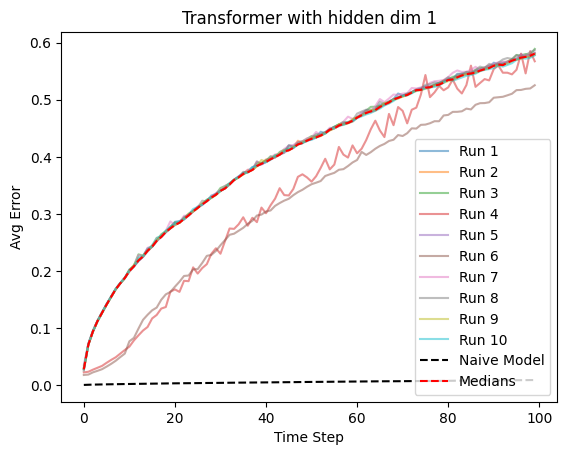

In [9]:
evaluate('Transformer',1)

In [13]:
evaluate('RoFormer',1)

: 

In [6]:
evaluate('Mamba',1)

ModuleNotFoundError: No module named 'mamba_ssm'

# RNN Evaluation

C:\Users\Sathya\AppData\Local\Temp\ipykernel_3196\4043365812.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_weight_paths[i]))
Un

{'model_name': 'RNN',
 'hidden_dim': 8,
 'E_10': tensor(0.0215),
 'E_100': tensor(0.2158),
 'flops_inf': 320000}

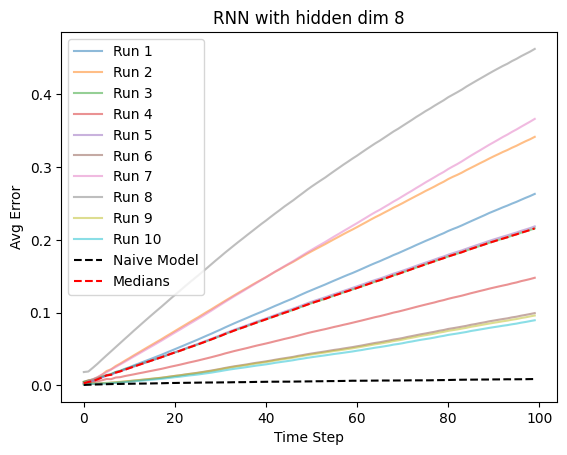

In [27]:
evaluate('RNN', 8)

C:\Users\Sathya\AppData\Local\Temp\ipykernel_3196\4043365812.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_weight_paths[i]))
Un

{'model_name': 'RNN',
 'hidden_dim': 16,
 'E_10': tensor(0.0073),
 'E_100': tensor(0.0586),
 'flops_inf': 640000}

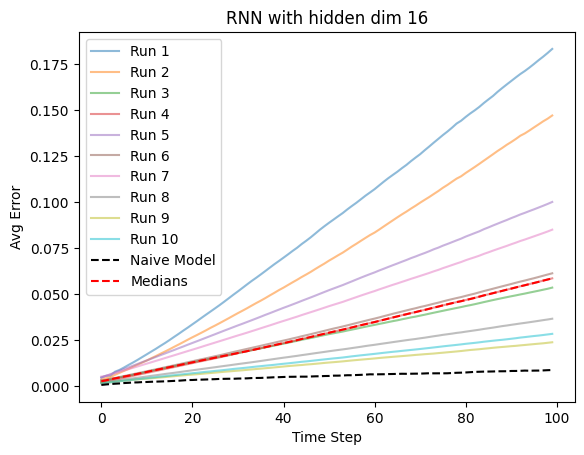

In [28]:
evaluate('RNN', 16)

C:\Users\Sathya\AppData\Local\Temp\ipykernel_3196\4043365812.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_weight_paths[i]))
Un

{'model_name': 'RNN',
 'hidden_dim': 32,
 'E_10': tensor(0.0062),
 'E_100': tensor(0.0464),
 'flops_inf': 1280000}

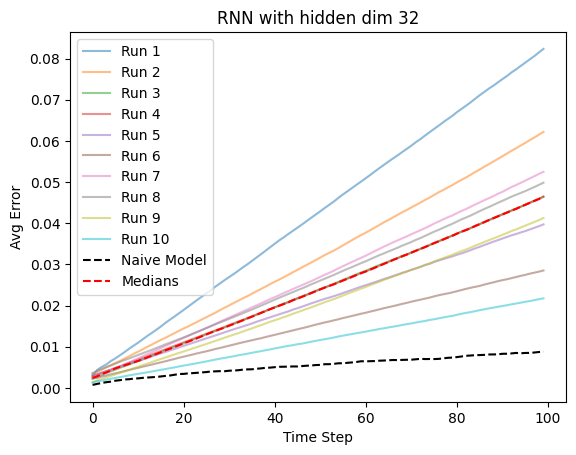

In [29]:
evaluate('RNN', 32)

C:\Users\Sathya\AppData\Local\Temp\ipykernel_3196\4043365812.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_weight_paths[i]))
Un

{'model_name': 'RNN',
 'hidden_dim': 64,
 'E_10': tensor(0.0065),
 'E_100': tensor(0.0402),
 'flops_inf': 2560000}

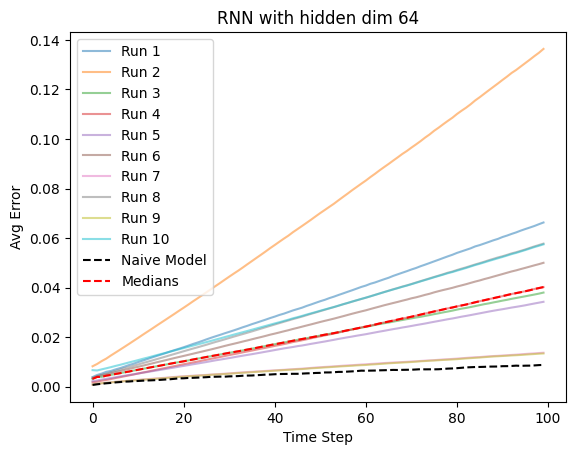

In [30]:
evaluate('RNN', 64)

C:\Users\Sathya\AppData\Local\Temp\ipykernel_3196\4043365812.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_weight_paths[i]))
Un

{'model_name': 'RNN',
 'hidden_dim': 128,
 'E_10': tensor(0.0058),
 'E_100': tensor(0.0400),
 'flops_inf': 5120000}

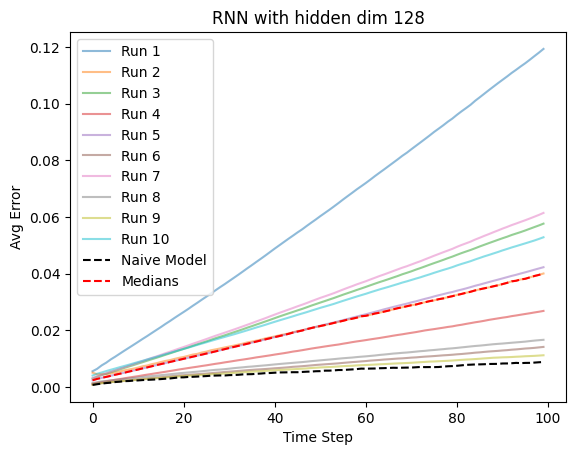

In [31]:
evaluate('RNN', 128)

# LSTM Evaluation

C:\Users\Sathya\AppData\Local\Temp\ipykernel_3196\1675740392.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_weight_paths[i]))
Un

{'model_name': 'LSTM',
 'hidden_dim': 8,
 'E_10': tensor(0.0061),
 'E_100': tensor(0.1664),
 'flops_inf': 320000}

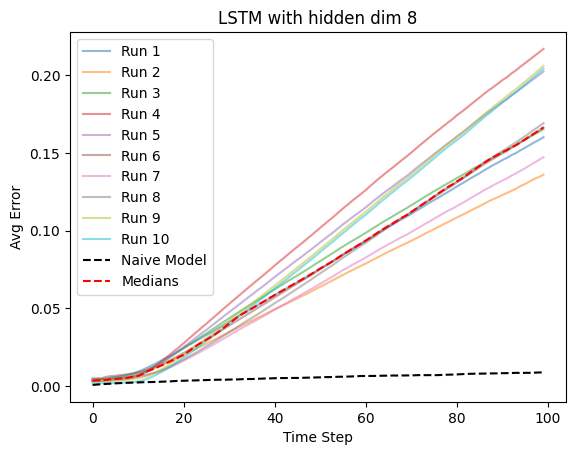

In [35]:
evaluate('LSTM', 8)

C:\Users\Sathya\AppData\Local\Temp\ipykernel_3196\1675740392.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_weight_paths[i]))
Un

{'model_name': 'LSTM',
 'hidden_dim': 16,
 'E_10': tensor(0.0064),
 'E_100': tensor(0.0691),
 'flops_inf': 640000}

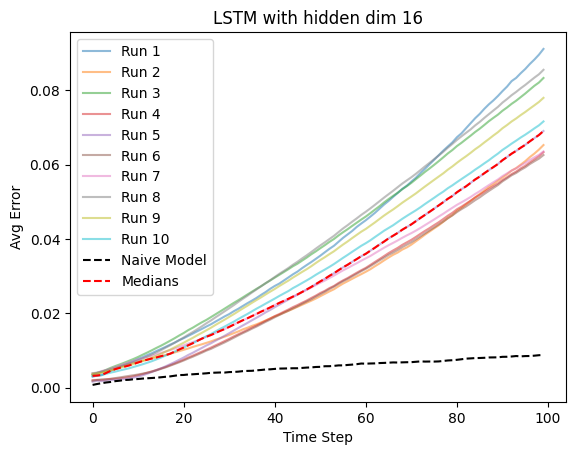

In [36]:
evaluate('LSTM', 16)

C:\Users\Sathya\AppData\Local\Temp\ipykernel_3452\1675740392.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_weight_paths[i]))
Un

{'model_name': 'LSTM',
 'hidden_dim': 32,
 'E_10': tensor(0.0039),
 'E_100': tensor(0.0788),
 'flops_inf': 1280000}

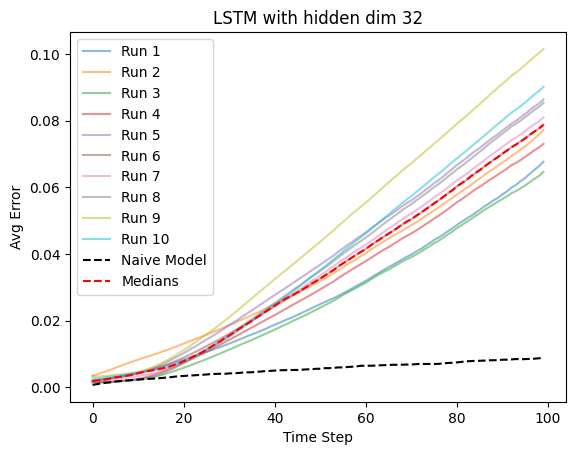

In [3]:
evaluate('LSTM', 32)

In [4]:
evaluate('LSTM', 64)

C:\Users\Sathya\AppData\Local\Temp\ipykernel_3452\1675740392.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_weight_paths[i]))


: 

In [ ]:
evaluate('LSTM', 128)

# GRU Evaluation

C:\Users\Sathya\AppData\Local\Temp\ipykernel_3196\1675740392.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_weight_paths[i]))
Un

{'model_name': 'GRU',
 'hidden_dim': 8,
 'E_10': tensor(0.0030),
 'E_100': tensor(0.2644),
 'flops_inf': 320000}

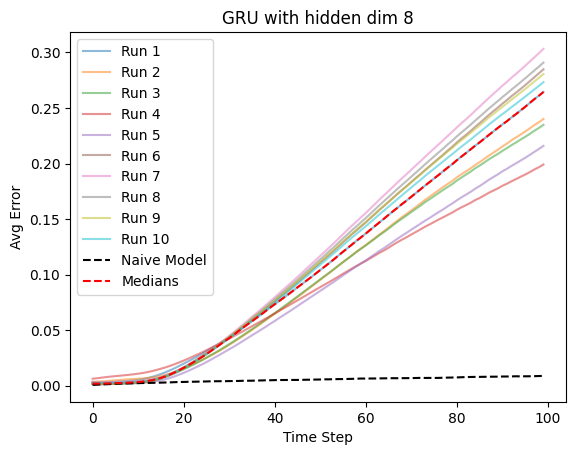

In [38]:
evaluate('GRU', 8)

C:\Users\Sathya\AppData\Local\Temp\ipykernel_3196\1675740392.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_weight_paths[i]))
Un

{'model_name': 'GRU',
 'hidden_dim': 16,
 'E_10': tensor(0.0027),
 'E_100': tensor(0.1489),
 'flops_inf': 640000}

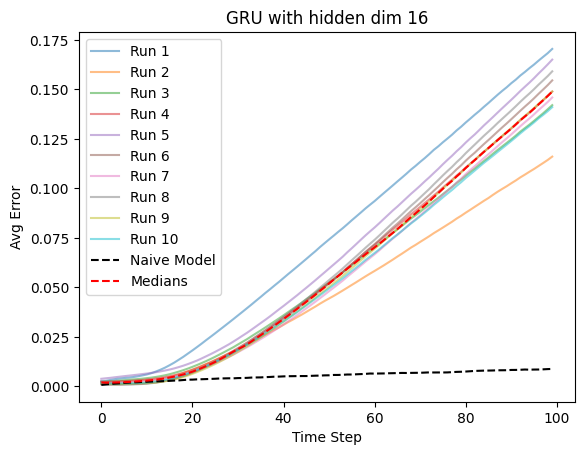

In [39]:
evaluate('GRU', 16)

C:\Users\Sathya\AppData\Local\Temp\ipykernel_3196\1675740392.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_weight_paths[i]))
Un

{'model_name': 'GRU',
 'hidden_dim': 32,
 'E_10': tensor(0.0020),
 'E_100': tensor(0.1047),
 'flops_inf': 1280000}

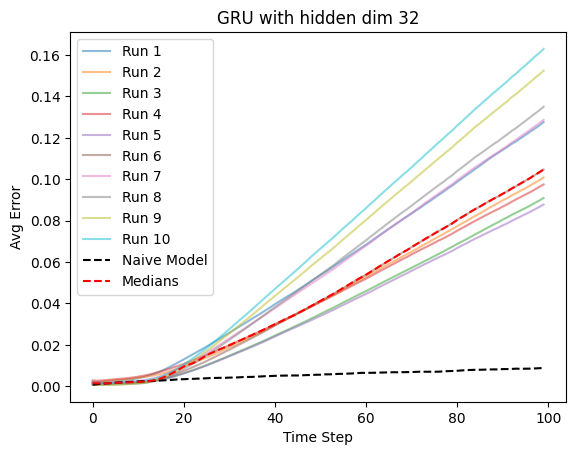

In [40]:
evaluate('GRU', 32)

C:\Users\Sathya\AppData\Local\Temp\ipykernel_3196\1675740392.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_weight_paths[i]))
Un

{'model_name': 'GRU',
 'hidden_dim': 64,
 'E_10': tensor(0.0014),
 'E_100': tensor(0.1078),
 'flops_inf': 2560000}

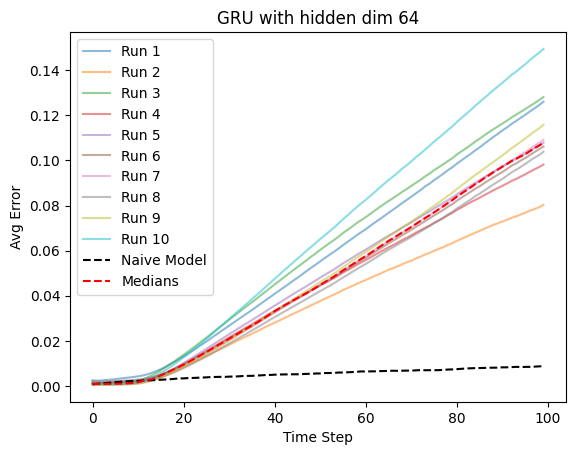

In [41]:
evaluate('GRU', 64)

In [42]:
evaluate('GRU', 128)

C:\Users\Sathya\AppData\Local\Temp\ipykernel_3196\1675740392.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_weight_paths[i]))


: 

# 2LRNN

C:\Users\Sathya\AppData\Local\Temp\ipykernel_26412\2404931045.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_weight_paths[i], ma

{'model_name': 'RNN_multilayer',
 'hidden_dim': 8,
 'E_10': tensor(0.0054),
 'E_100': tensor(0.0773),
 'flops_inf': 16320000}

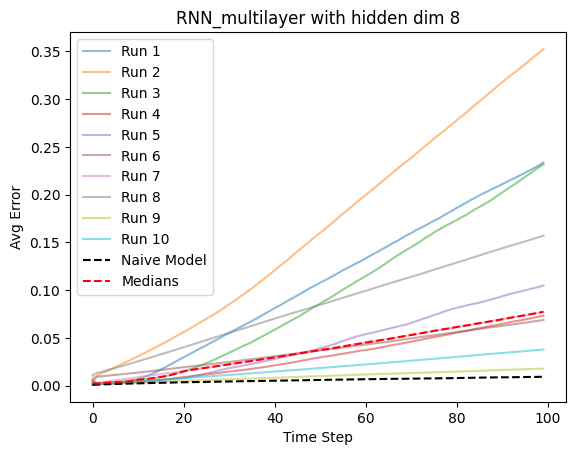

In [6]:
evaluate('RNN_multilayer', 8)

C:\Users\Sathya\AppData\Local\Temp\ipykernel_26412\2404931045.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_weight_paths[i], ma

{'model_name': 'RNN_multilayer',
 'hidden_dim': 16,
 'E_10': tensor(0.0046),
 'E_100': tensor(0.0367),
 'flops_inf': 32640000}

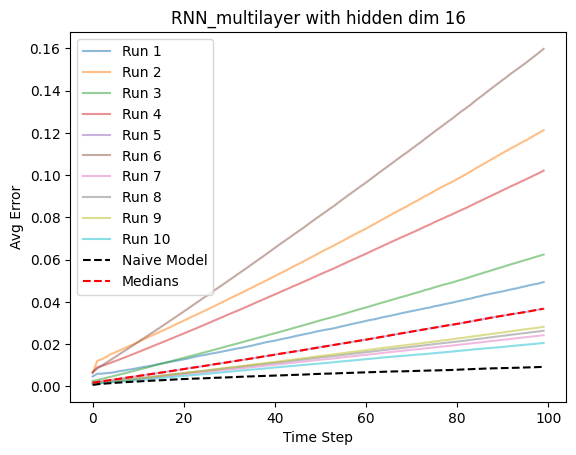

In [7]:
evaluate('RNN_multilayer', 16)

C:\Users\Sathya\AppData\Local\Temp\ipykernel_26412\2404931045.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_weight_paths[i], ma

{'model_name': 'RNN_multilayer',
 'hidden_dim': 32,
 'E_10': tensor(0.0054),
 'E_100': tensor(0.0365),
 'flops_inf': 65280000}

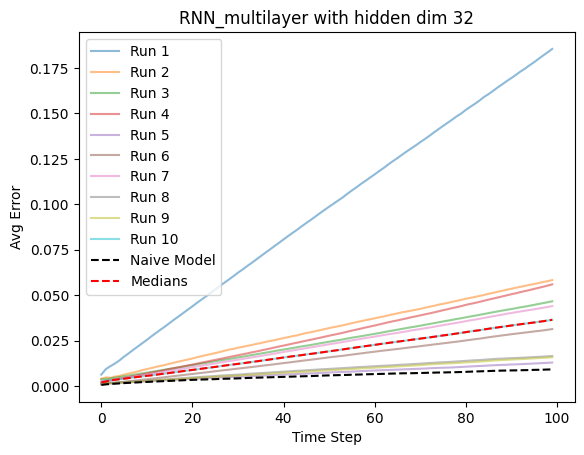

In [8]:
evaluate('RNN_multilayer', 32)

C:\Users\Sathya\AppData\Local\Temp\ipykernel_29016\2404931045.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_weight_paths[i], ma

{'model_name': 'RNN_multilayer',
 'hidden_dim': 64,
 'E_10': tensor(0.0062),
 'E_100': tensor(0.0494),
 'flops_inf': 130560000}

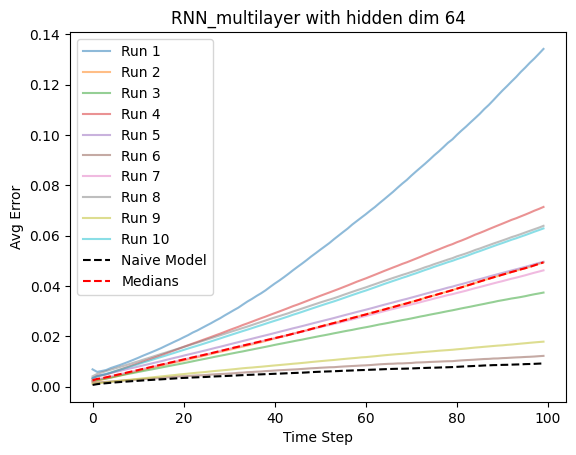

In [3]:
evaluate('RNN_multilayer', 64)

In [10]:
evaluate('RNN_multilayer', 128)

C:\Users\Sathya\AppData\Local\Temp\ipykernel_28224\2404931045.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_weight_paths[i], ma

: 

# Misc

In [ ]:
models = {d:[models.RNN(hidden_size=d) for _ in range(10)] for d in hidden_dims}
model_weight_paths = {d:[f'hpc_results\hidden_dim_{d}_{i}.pth' for i in range(10)] for d in hidden_dims}

for d in hidden_dims:
    for i, model in enumerate(models[d]):
        model.load_state_dict(torch.load(model_weight_paths[d][i]))

In [14]:
X0_test.shape, V_test.shape, pos_test.shape

(torch.Size([10000, 2]),
 torch.Size([10000, 100, 2]),
 torch.Size([10000, 100, 2]))

In [ ]:
model = models[8][0]
model.eval()
n_steps = V.shape[1]

pos_pred = torch.zeros_like(pos_test)
with torch.no_grad():
    for i in range(n_steps):
        pos_pred[:,i] = model(x_0=X0_test, V=V_test[:,:i+1]).squeeze()

(pos_test[:,0]-pos_pred[:,0]).norm(dim=-1).mean()

tensor(0.0022)

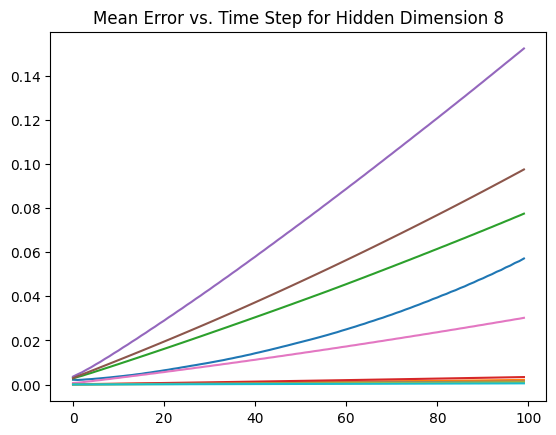

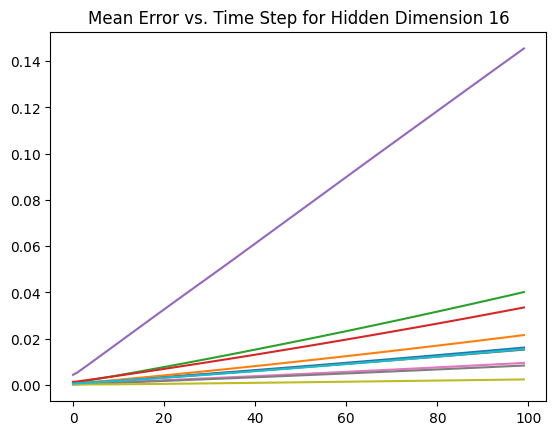

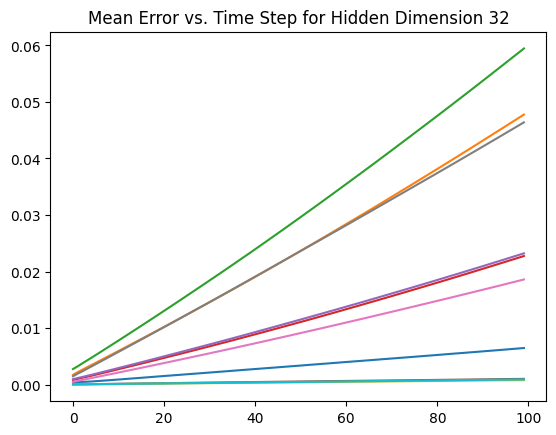

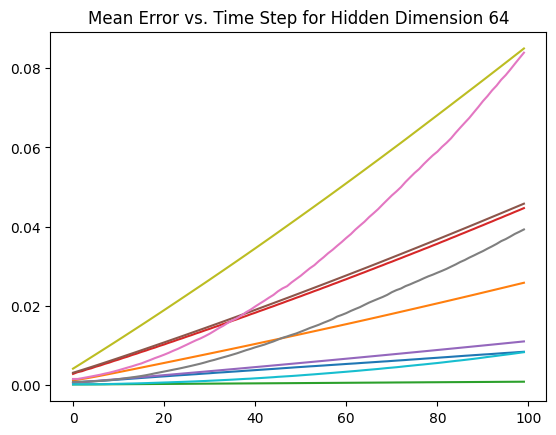

In [ ]:
import matplotlib.pyplot as plt

for d in hidden_dims:
    for run in range(10):
        model = models[d][run]
        model.eval()
        n_steps = V.shape[1]

        pos_pred = torch.zeros_like(pos_test)
        with torch.no_grad():
            for i in range(n_steps):
                pos_pred[:,i] = model(x_0=X0_test, V=V_test[:,:i+1]).squeeze()

        (pos_test[:,0]-pos_pred[:,0]).norm(dim=-1).mean()
        mean_errors = (pos_test-pos_pred).norm(dim=-1).mean(dim=0)
        plt.plot(mean_errors)
    plt.title(f'Mean Error vs. Time Step for Hidden Dimension {d}')
    plt.show()

In [32]:
pos_pred

tensor([[[ 0.4225, -0.0594],
         [ 0.3375, -0.0823],
         [ 0.3388, -0.1706],
         ...,
         [ 0.5907, -0.2654],
         [ 0.6375, -0.2928],
         [ 0.6318, -0.2634]],

        [[ 0.1917,  0.4015],
         [ 0.1754,  0.4066],
         [ 0.1891,  0.4074],
         ...,
         [ 0.0026,  0.3897],
         [-0.0676,  0.3484],
         [-0.0236,  0.4108]],

        [[ 0.5436, -0.3787],
         [ 0.5024, -0.3963],
         [ 0.5519, -0.4136],
         ...,
         [ 0.5519, -0.6225],
         [ 0.6034, -0.6495],
         [ 0.6406, -0.6274]],

        ...,

        [[ 0.5504,  0.3651],
         [ 0.5400,  0.3831],
         [ 0.5488,  0.4077],
         ...,
         [ 0.4045, -0.0135],
         [ 0.3417,  0.0438],
         [ 0.2982,  0.0760]],

        [[ 0.0741, -0.5243],
         [ 0.1146, -0.5600],
         [ 0.2018, -0.6011],
         ...,
         [ 0.9047, -0.5683],
         [ 0.8316, -0.5940],
         [ 0.8790, -0.5461]],

        [[-0.0370,  0.4477],
       